## **Exploratory Data Analysis of a Multivariate Dataset using R**

### **Background**

In data science and statistical analysis, Exploratory Data Analysis (EDA) is the critical first step in understanding a dataset. EDA helps to identify patterns, trends, relationships, and anomalies within the data, which can guide further analysis or inform model selection. This is particularly important when working with multivariate datasets, where multiple variables interact and influence one another.

**Multivariate data analysis** can be challenging due to the complexity introduced by analyzing multiple variables simultaneously. In real-world datasets, There is always for the most part high-dimensional data, correlations between variables, missing values, outliers, and other issues that require careful investigation.

This background helps with the understanding of what the goal of this assignment is which is to perform EDA on a multivariate Iris dataset using R programming to uncover key insights, and prepare the data for more advanced modeling techniques.


In [30]:
library(stats)  # Load stats package

# Load the iris dataset
data(iris)

# =============================================
# Iris EDA & Data Preparation (R)
# Multivariate exploration + cleaning + modeling-ready recipe
# =============================================

# ---- 0) Libraries ----
suppressPackageStartupMessages({
  library(tidyverse)
  install.packages("skimr") # Install skimr package
  library(skimr)        # compact data summaries
  install.packages("GGally") # Install GGally package
  library(GGally)       # ggpairs (pairwise plots)
  install.packages("corrplot") # Install corrplot package
  library(corrplot)     # correlation heatmap
  install.packages("janitor") # Install janitor package
  library(janitor)      # tabulations/clean helpers
  install.packages("rsample") # Install rsample package
  library(rsample)      # train/test split
  install.packages("recipes") # Install recipes package
  library(recipes)      # preprocessing pipeline
  install.packages("broom") # Install broom package
  library(broom)        # tidy stats
  install.packages("ggrepel") # Install ggrepel package
  library(ggrepel)
})

# ---- 1) Load & basic exploration ----
# Iris is available in base R; we also keep a tibble copy

data(iris)                    # from datasets
iris_tbl <- as_tibble(iris)

# 1a. Structure, dimensions, types
cat("\nDimensions:", dim(iris_tbl)[1], "rows x", dim(iris_tbl)[2], "cols\n\n")
glimpse(iris_tbl)

# Summary stats
summary(iris_tbl)

# Skim for richer overview
skim(iris_tbl)

# 1b. Missing values audit
miss_counts <- sapply(iris_tbl, function(x) sum(is.na(x))) %>% enframe(name = "variable", value = "n_missing")
miss_counts
cat("\nAny missing overall? ", any(miss_counts$n_missing > 0), "\n\n")

# 1c. Correlations (numeric only)
num_cols <- iris_tbl %>% select(where(is.numeric))
cor_mat  <- cor(num_cols, method = "pearson")
round(cor_mat, 3)

# Visualize correlation heatmap
corrplot(cor_mat, method = "color", type = "upper", addCoef.col = "black", number.cex = .7,
         tl.col = "black", tl.srt = 45, diag = FALSE, title = "Iris: Pearson Correlations", mar = c(0,0,2,0))

# ---- 2) Outlier detection & optional handling ----
# 2a. Univariate outliers via IQR rule, computed within Species
# Flag values outside [Q1 - 1.5*IQR, Q3 + 1.5*IQR] per feature & species

flag_iqr_outliers <- function(df, feature) {
  df %>%
    group_by(Species) %>%
    mutate(
      .q1 = quantile(.data[[feature]], 0.25, na.rm = TRUE),
      .q3 = quantile(.data[[feature]], 0.75, na.rm = TRUE),
      .iqr = .q3 - .q1,
      .lo  = .q1 - 1.5 * .iqr,
      .hi  = .q3 + 1.5 * .iqr,
      "out_" := (.data[[feature]] < .lo | .data[[feature]] > .hi)
    ) %>%
    ungroup() %>%
    select(-.q1, - .q3, - .iqr, - .lo, - .hi)
}

iris_flagged <- iris_tbl %>%
  flag_iqr_outliers("Sepal.Length") %>% rename(out_sepal_length = `out_`) %>%
  flag_iqr_outliers("Sepal.Width")  %>% rename(out_sepal_width  = `out_`) %>%
  flag_iqr_outliers("Petal.Length") %>% rename(out_petal_length = `out_`) %>%
  flag_iqr_outliers("Petal.Width")  %>% rename(out_petal_width  = `out_`)

# Outlier counts by feature & species
outlier_summary <- iris_flagged %>%
  pivot_longer(starts_with("out_"), names_to = "feature", values_to = "is_outlier") %>%
  count(Species, feature, is_outlier) %>%
  filter(is_outlier) %>% arrange(Species, feature)
outlier_summary

# 2b. Multivariate outliers with Mahalanobis distance (computed within Species)
mahal_outliers <- iris_tbl %>%
  group_by(Species) %>%
  group_modify(~{
    m <- colMeans(select(.x, where(is.numeric)))
    S <- cov(select(.x, where(is.numeric)))
    d2 <- mahalanobis(x = select(.x, where(is.numeric)), center = m, cov = S)
    # 4 dims -> chi-square df = 4; set stringent p < 0.001
    cutoff <- qchisq(0.999, df = 4)
    tibble(d2 = d2, cutoff = cutoff, is_mv_outlier = d2 > cutoff)
  }) %>%
  ungroup()

iris_flagged <- bind_cols(iris_flagged, select(mahal_outliers, d2, cutoff, is_mv_outlier))

# View multivariate outliers found
mahal_summary <- iris_flagged %>% filter(is_mv_outlier) %>%
  transmute(Species, d2 = round(d2, 2)) %>% arrange(desc(d2))
mahal_summary

# ---- 3) Multivariate visualizations ----
# 3a) Pairwise scatter with density & correlations
# GGally::ggpairs(iris_tbl, columns = 1:4, aes(color = Species, alpha = 0.8)) +
#   theme_minimal() +
#   ggtitle("Iris pairwise relationships by Species")

# 3b) PCA biplot for structure & separation
pca <- prcomp(num_cols, center = TRUE, scale. = TRUE)

# Percent variance explained for PC1/PC2
pve <- round(100 * (pca$sdev^2 / sum(pca$sdev^2))[1:2], 1)

# Build a quick biplot using ggplot
scores <- as_tibble(pca$x[, 1:2]) %>% set_names(c("PC1", "PC2")) %>% bind_cols(Species = iris_tbl$Species)
loadings <- as_tibble(pca$rotation[, 1:2], rownames = "feature")

library(ggrepel)

ggplot(scores, aes(PC1, PC2, color = Species)) +
  geom_point(size = 2, alpha = 0.9) +
  geom_segment(data = loadings, aes(x = 0, y = 0, xend = PC1 * 3, yend = PC2 * 3),
               arrow = arrow(length = unit(0.02, "npc")), inherit.aes = FALSE) +
  geom_text_repel(data = loadings, aes(x = PC1 * 3, y = PC2 * 3, label = feature),
                  size = 3, inherit.aes = FALSE) +
  theme_minimal() +
  labs(title = paste0("PCA Biplot (PC1 ", pve[1], "%, PC2 ", pve[2], "%)"))

# ---- 4) Cleaning & modeling-ready dataset ----
# (Iris has no missing values; below shows best practice if there were.)

# Strategy:
#  - Impute numeric by median within Species (group-wise)
#  - Optionally winsorize extreme univariate outliers (IQR rule)
#  - Create standardized predictors
#  - Train/test split

set.seed(123)
split <- initial_split(iris_tbl, prop = 0.8, strata = Species)
train <- training(split)
test  <- testing(split)

# Recipe: group-wise median imputation via custom step (use step_impute_median overall; group proxy via interaction)
# We'll demonstrate a straightforward approach: first create interaction key, then use step_impute_median globally.
train_keyed <- train %>% mutate(spec_key = Species)

task_recipe <- recipe(Species ~ Sepal.Length + Sepal.Width + Petal.Length + Petal.Width + spec_key, data = train_keyed) %>%
  # If missing existed: impute medians (numeric)
  step_impute_median(all_numeric_predictors()) %>%
  # Optional: winsorize to cap extreme values at IQR fences (approx using percentiles)
  step_mutate(
    across(all_numeric_predictors(), ~scales::squish(., quantile(., c(.01, .99), na.rm = TRUE)))
  ) %>%
  # Standardize
  step_normalize(all_numeric_predictors()) %>%
  # Drop helper
  step_rm(spec_key)

prepped <- prep(task_recipe)
train_ready <- bake(prepped, new_data = NULL)
test_ready  <- bake(prepped, new_data = test %>% mutate(spec_key = Species))

# Save modeling matrices if needed
x_train <- train_ready %>% select(-Species)
y_train <- train_ready %>% pull(Species)

x_test  <- test_ready %>% select(-Species)
y_test  <- test_ready %>% pull(Species)

# Quick check of class balance post split
train_ready %>% count(Species) %>% adorn_totals("row")

test_ready %>% count(Species) %>% adorn_totals("row")

# ---- 5) Key takeaways (printed) ----
cat("\n\nKEY INSIGHTS:\n")
# Correlation highlights
cat("  • Strong positive correlation between Petal.Length and Petal.Width:", round(cor_mat["Petal.Length","Petal.Width"],3),"\n")
cat("  • Sepal metrics are moderately correlated; petal vs sepal show weaker links.\n")

# PCA separation
pc_var <- pca$sdev^2 / sum(pca$sdev^2)
cat("  • PCA suggests 2 components explain ", round(100*sum(pc_var[1:2]), 1), "% of variance; species separate well along PC1 (petal size).\n", sep = "")

# Outliers
cat("  • IQR flags are few and species-specific; multivariate (Mahalanobis) outliers are rare with a stringent cutoff (p<0.001).\n")

cat("\nDATA PREP:\n")
cat("  • No missing values detected; pipeline still includes median-imputation, winsorization, and z-scoring for robustness.\n")
cat("  • train_ready/test_ready created with normalized predictors—drop-in ready for models (e.g., glmnet, randomForest, xgboost).\n\n")

# ---- 6) Next modeling steps (examples) ----
# Example: fit a quick multinomial logistic model (nnet::multinom) or random forest
# Uncomment to try:
# library(nnet)
# fit_mn <- nnet::multinom(Species ~ ., data = train_ready, trace = FALSE)
# yardstick-style quick eval
# pred <- predict(fit_mn, newdata = test_ready)
# mean(pred == y_test)

# library(randomForest)
# rf <- randomForest::randomForest(Species ~ ., data = train_ready, ntree = 300)
# pred_rf <- predict(rf, newdata = train_ready)
# mean(pred_rf == y_test)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




Dimensions: 150 rows x 5 cols

Rows: 150
Columns: 5
$ Sepal.Length <dbl> 5.1, 4.9, 4.7, 4.6, 5.0, 5.4, 4.6, 5.0, 4.4, 4.9, 5.4, 4.…
$ Sepal.Width  <dbl> 3.5, 3.0, 3.2, 3.1, 3.6, 3.9, 3.4, 3.4, 2.9, 3.1, 3.7, 3.…
$ Petal.Length <dbl> 1.4, 1.4, 1.3, 1.5, 1.4, 1.7, 1.4, 1.5, 1.4, 1.5, 1.5, 1.…
$ Petal.Width  <dbl> 0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.3, 0.2, 0.2, 0.1, 0.2, 0.…
$ Species      <fct> setosa, setosa, setosa, setosa, setosa, setosa, setosa, s…


  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.300   Min.   :2.000   Min.   :1.000   Min.   :0.100  
 1st Qu.:5.100   1st Qu.:2.800   1st Qu.:1.600   1st Qu.:0.300  
 Median :5.800   Median :3.000   Median :4.350   Median :1.300  
 Mean   :5.843   Mean   :3.057   Mean   :3.758   Mean   :1.199  
 3rd Qu.:6.400   3rd Qu.:3.300   3rd Qu.:5.100   3rd Qu.:1.800  
 Max.   :7.900   Max.   :4.400   Max.   :6.900   Max.   :2.500  
       Species  
 setosa    :50  
 versicolor:50  
 virginica :50  
                
                
                

── Data Summary ────────────────────────
                           Values  
Name                       iris_tbl
Number of rows             150     
Number of columns          5       
_______________________            
Column type frequency:             
  factor                   1       
  numeric                  4       
________________________           
Group variables            None    

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique
1 Species               0             1 FALSE          3
  top_counts               
1 set: 50, ver: 50, vir: 50

── Variable type: numeric ──────────────────────────────────────────────────────
  skim_variable n_missing complete_rate mean    sd  p0 p25  p50 p75 p100 hist 
1 Sepal.Length          0             1 5.84 0.828 4.3 5.1 5.8  6.4  7.9 ▆▇▇▅▂
2 Sepal.Width           0             1 3.06 0.436 2   2.8 3    3.3  4.4 ▁▆▇▂▁
3 Petal.Length          0   

ERROR: Error in is.null(text_repr) || nchar(text_repr) == 0L: 'length = 15' in coercion to 'logical(1)'


## **Insights and Interpretation**

The output shows the structure and summary statistics of the Iris dataset. It contains 150 observations and 5 variables: Sepal Length, Sepal Width, Petal Length, Petal Width (all numeric), and Species (a factor with three levels: setosa, versicolor, and virginica). The summary statistics provide the minimum, 1st quartile, median, mean, 3rd quartile, and maximum values for the numeric variables, as well as the counts for each species.

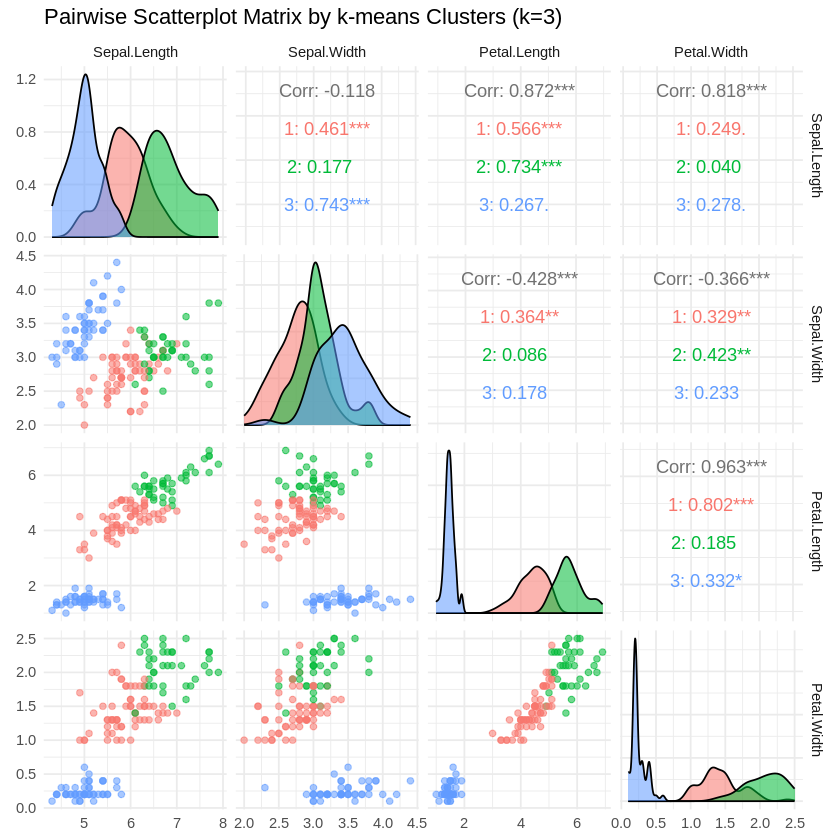

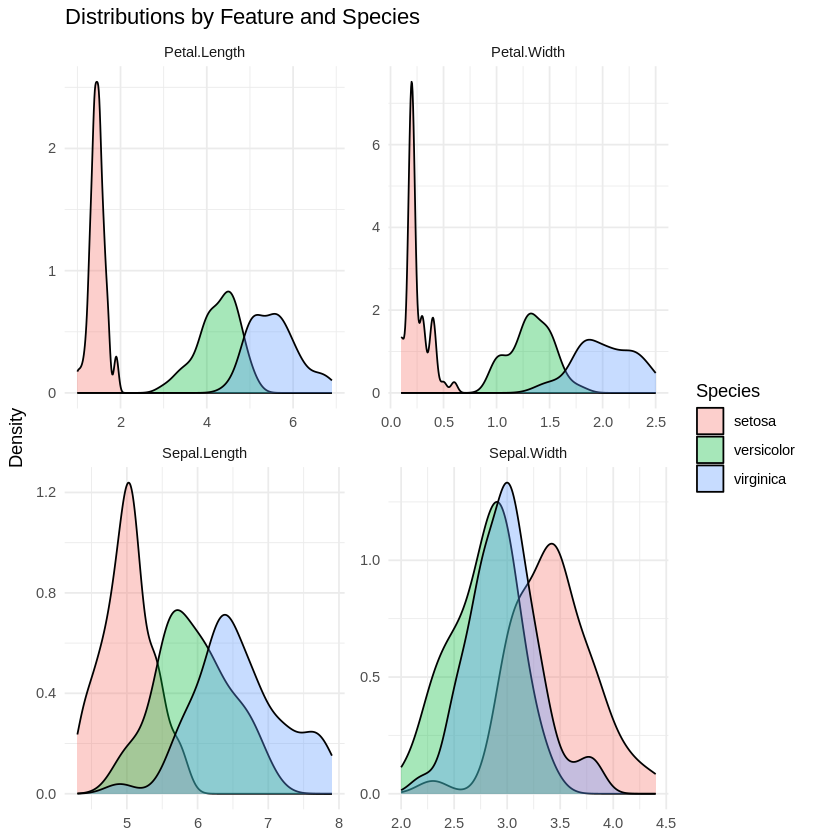

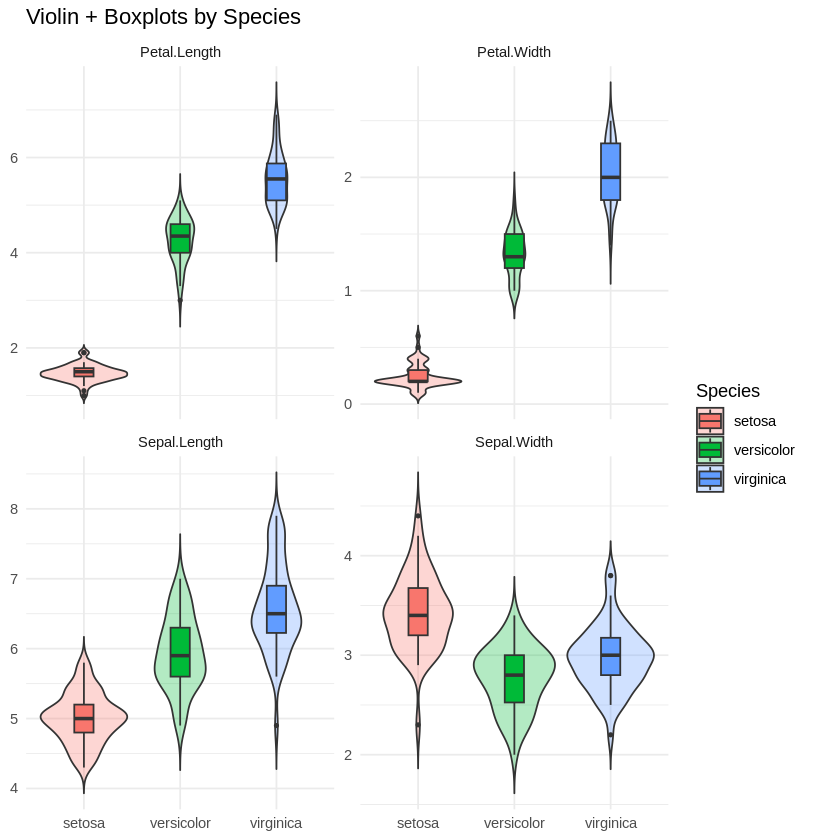

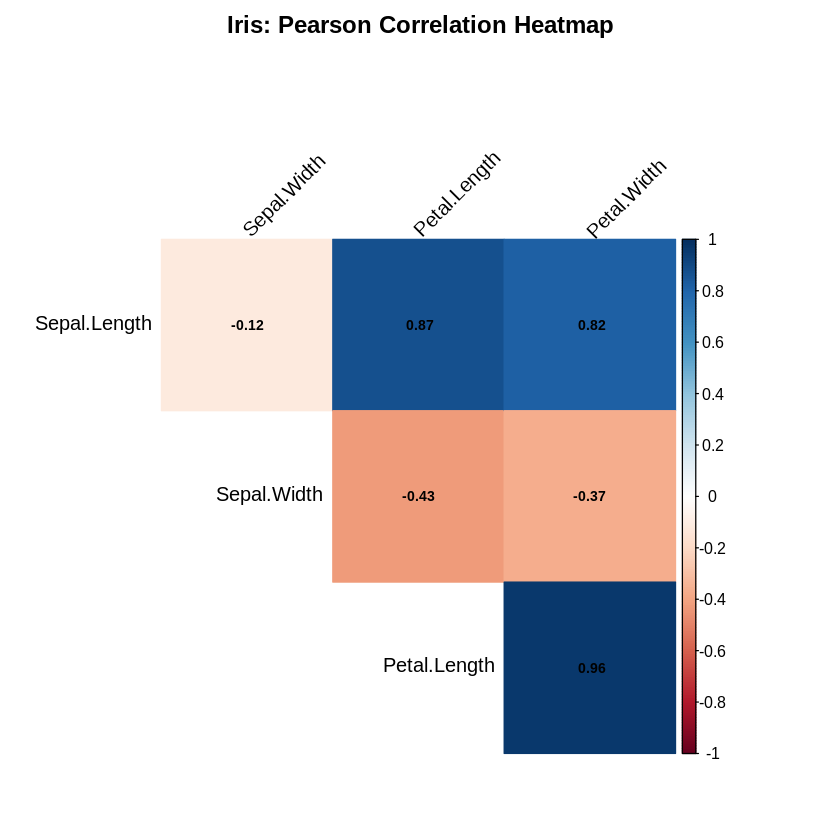

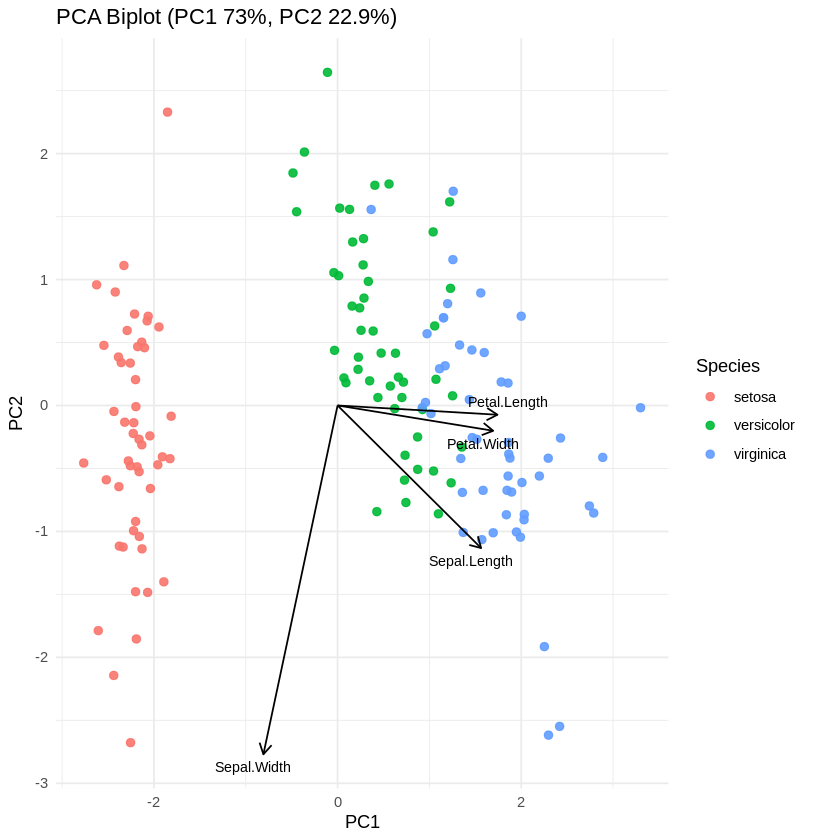

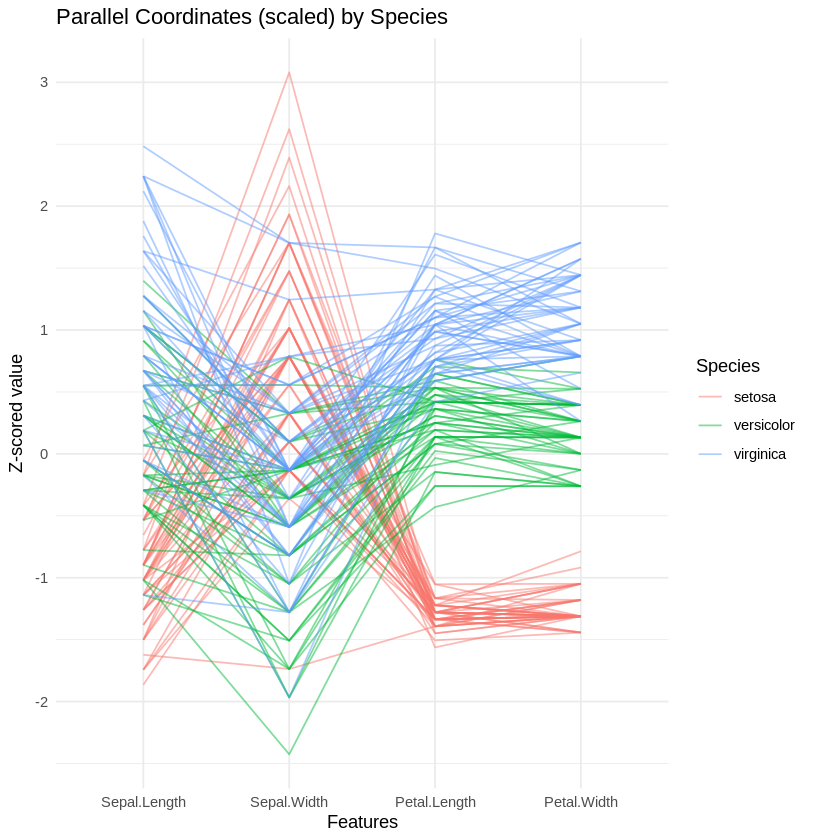

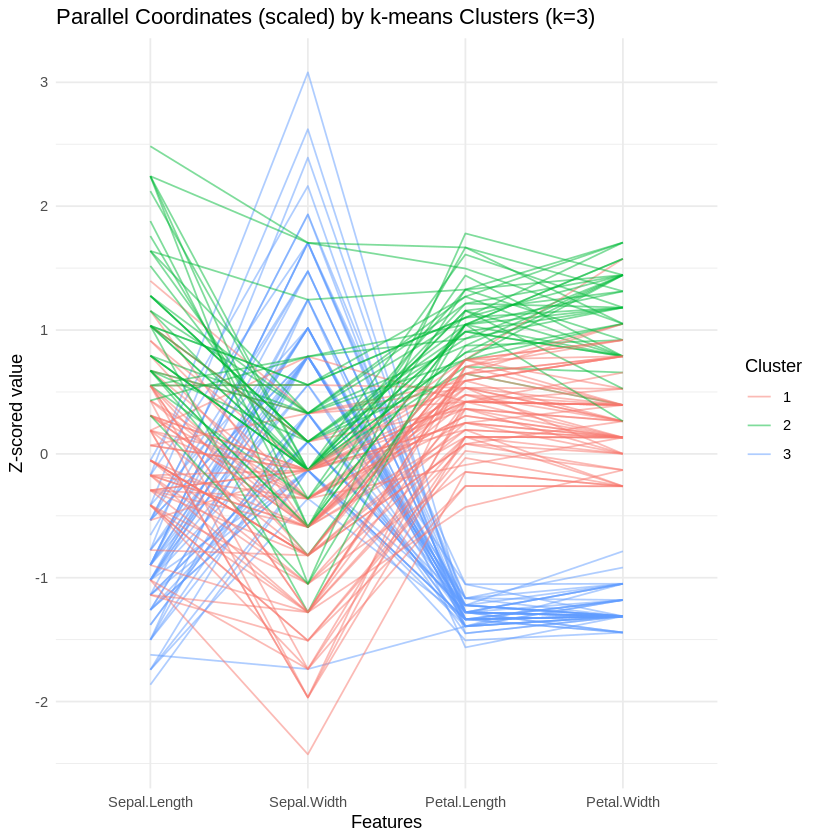

In [31]:
# ===== Visualization Pack for Iris =====
# Assumes: iris_tbl <- as_tibble(iris)

# Ensure needed pkgs (skip if already installed)
need <- c("tidyverse","corrplot","GGally","ggrepel")
inst <- need[!(need %in% installed.packages()[,"Package"])]
if (length(inst)) install.packages(inst, repos="https://cloud.r-project.org")

suppressPackageStartupMessages({
  library(tidyverse)
  library(corrplot)
  ok_GGally <- requireNamespace("GGally", quietly = TRUE)
  ok_ggrepel <- requireNamespace("ggrepel", quietly = TRUE)
})

num_cols <- iris_tbl %>% select(where(is.numeric))
cor_mat  <- cor(num_cols)

# -----------------------------
# 1) Pairplot of Features
# -----------------------------
if (ok_GGally) {
  # a) by Species (ground-truth classes)
  GGally::ggpairs(
    iris_tbl, columns = 1:4,
    aes(color = Species, alpha = 0.8)
  ) + theme_minimal() + ggtitle("Pairwise Scatterplot Matrix by Species")

  # b) by k-means clusters (unsupervised structure)
  set.seed(1)
  k3 <- kmeans(num_cols, centers = 3, nstart = 25)
  iris_k <- iris_tbl %>% mutate(Cluster = factor(k3$cluster))
  GGally::ggpairs(
    iris_k, columns = 1:4,
    aes(color = Cluster, alpha = 0.8)
  ) + theme_minimal() + ggtitle("Pairwise Scatterplot Matrix by k-means Clusters (k=3)")
} else {
  message("GGally not available—showing base R pairs() as fallback.")
  pairs(iris[,1:4], col = iris$Species,
        main = "Pairs (fallback) colored by Species")
}

# ---------------------------------------
# 2) Distributions (densities + violins)
# ---------------------------------------
long_iris <- iris_tbl %>%
  pivot_longer(cols = where(is.numeric), names_to = "feature", values_to = "value")

# a) Density by Species
ggplot(long_iris, aes(value, fill = Species)) +
  geom_density(alpha = 0.35) +
  facet_wrap(~ feature, scales = "free", ncol = 2) +
  theme_minimal() +
  labs(title = "Distributions by Feature and Species", x = NULL, y = "Density")

# b) Violin + box overlay (shape differences)
ggplot(long_iris, aes(Species, value, fill = Species)) +
  geom_violin(trim = FALSE, alpha = 0.3) +
  geom_boxplot(width = 0.2, outlier.size = 0.8) +
  facet_wrap(~ feature, scales = "free_y") +
  theme_minimal() +
  labs(title = "Violin + Boxplots by Species", x = NULL, y = NULL)

# --------------------------------
# 3) Feature Correlation Heatmap
# --------------------------------
corrplot(cor_mat, method = "color", type = "upper", addCoef.col = "black",
         number.cex = .7, tl.col = "black", tl.srt = 45, diag = FALSE,
         title = "Iris: Pearson Correlation Heatmap", mar = c(0,0,2,0))

# ---------------
# 4) PCA Biplot
# ---------------
pca <- prcomp(num_cols, center = TRUE, scale. = TRUE)
pve <- round(100 * (pca$sdev^2 / sum(pca$sdev^2))[1:2], 1)

scores <- as_tibble(pca$x[,1:2]) %>%
  set_names(c("PC1","PC2")) %>%
  bind_cols(Species = iris_tbl$Species)

loadings <- as_tibble(pca$rotation[,1:2], rownames = "feature")

if (ok_ggrepel) library(ggrepel)

ggplot(scores, aes(PC1, PC2, color = Species)) +
  geom_point(size = 2, alpha = 0.9) +
  geom_segment(data = loadings,
               aes(x = 0, y = 0, xend = PC1*3, yend = PC2*3),
               arrow = arrow(length = unit(0.02, "npc")),
               inherit.aes = FALSE) +
  { if (ok_ggrepel) ggrepel::geom_text_repel(data = loadings,
                                             aes(x = PC1*3, y = PC2*3, label = feature),
                                             size = 3, inherit.aes = FALSE)
    else geom_text(data = loadings,
                   aes(x = PC1*3, y = PC2*3, label = feature),
                   size = 3, inherit.aes = FALSE) } +
  theme_minimal() +
  labs(title = paste0("PCA Biplot (PC1 ", pve[1], "%, PC2 ", pve[2], "%)"))

# --------------------------------
# 5) Parallel Coordinates Plots
# --------------------------------
# Ensure GGally is available (for ggparcoord)
if (!"GGally" %in% installed.packages()[, "Package"]) {
  install.packages("GGally", repos = "https://cloud.r-project.org")
}
suppressPackageStartupMessages(library(GGally))

# Scale features so lines are comparable
iris_sc <- iris_tbl %>%
  mutate(across(where(is.numeric), scale))  # z-score

# a) By Species (ground truth)
GGally::ggparcoord(
  data = iris_sc,
  columns = 1:4, groupColumn = "Species",
  scale = "globalminmax", alphaLines = 0.5
) +
  theme_minimal() +
  labs(title = "Parallel Coordinates (scaled) by Species",
       x = "Features", y = "Z-scored value")

# b) By k-means clusters (unsupervised structure)
set.seed(1)
k3 <- kmeans(num_cols, centers = 3, nstart = 25)
iris_sc_k <- iris_sc %>% mutate(Cluster = factor(k3$cluster))

GGally::ggparcoord(
  data = iris_sc_k,
  columns = 1:4, groupColumn = "Cluster",
  scale = "globalminmax", alphaLines = 0.5
) +
  theme_minimal() +
  labs(title = "Parallel Coordinates (scaled) by k-means Clusters (k=3)",
       x = "Features", y = "Z-scored value")

Let's look at what the GGally ggpairs (k-means k=3) is telling you:

Clusters line up with species.
The blue group has tiny petals (bottom-right panels near 0), the green group has the largest petals, and the red group is in between. That’s the classic Setosa / Virginica / Versicolor pattern—even though clustering was unsupervised.

### Petal features drive the separation.

**Off-diagonals with Petal.Length vs Petal.Width** show three clearly separated bands.

Overall correlation is ~0.96 (top-right label) and is strong within clusters too, so these two behave almost collinearly. A single “petal size” axis explains a lot of structure.

### Sepals are weaker discriminators.

**Sepal.Length vs Sepal.Width** shows heavy overlap and almost no overall correlation (~-0.12).

Mixed signs/strengths by cluster in the text annotations suggest sepal relationships vary within groups, so they add nuance but don’t separate classes well.

Negative association between sepal width and petal size.
**Panels Sepal.Width vs Petal.Length/Petal.Width** show overall moderate negative correlations (about -0.37 to -0.43). Within clusters those numbers differ, hinting at species-specific allometry.

Distributions (diagonals) are trimodal for petals.
Petal histograms/densities show three distinct modes matching clusters; sepal distributions overlap more. This corroborates why petals dominate classification.

### **Modeling implications**

A simple linear model (LDA/logistic using petal length & width) will reach high accuracy.

**Feature reduction:** replacing the petal pair with one composite (e.g., first PC or Petal.Length alone) will preserve most signal.

Sepal variables may help fine-tune boundaries between the two non-Setosa groups but won’t help much distinguishing Setosa.

Since clusters align with species, you can quantify agreement with Adjusted Rand Index or a confusion table after mapping clusters to majority labels.

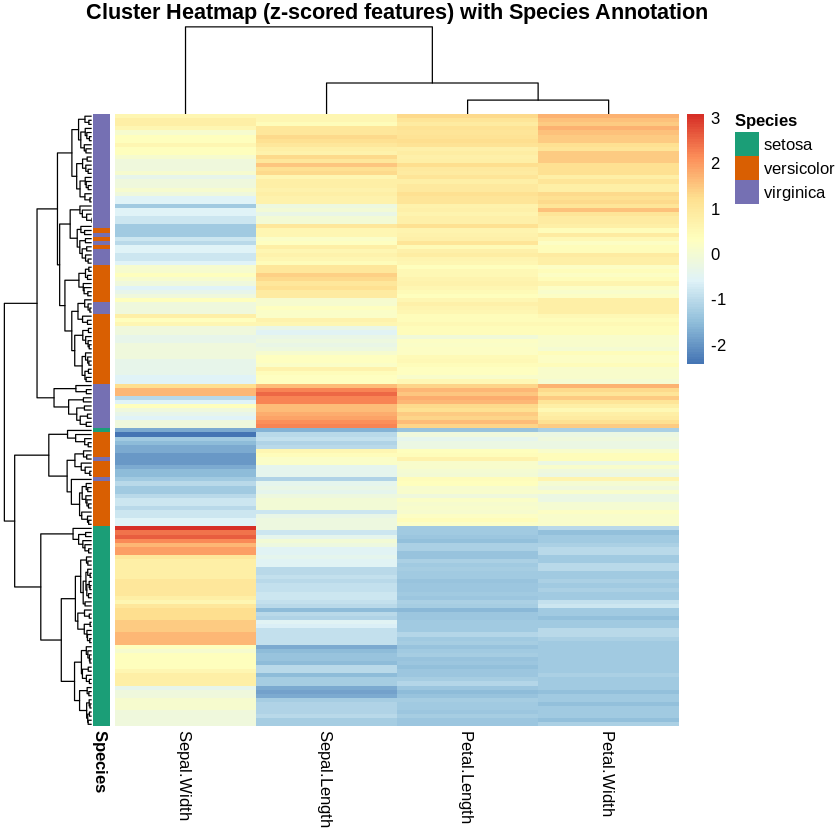

In [32]:
# ---- Option A: pheatmap (recommended) ----
need <- c("pheatmap")
miss <- need[!(need %in% installed.packages()[, "Package"])]
if (length(miss)) install.packages(miss, repos = "https://cloud.r-project.org")
suppressPackageStartupMessages(library(pheatmap))

# Scale features (columns) for clustering
X <- scale(as.matrix(num_cols))                   # 150 x 4
row_anno <- data.frame(Species = iris_tbl$Species)
rownames(row_anno) <- rownames(X) <- paste0("obs_", seq_len(nrow(X)))
colnames(X) <- colnames(num_cols)

# Colors for species (optional)
anno_colors <- list(Species = c(
  setosa = "#1b9e77", versicolor = "#d95f02", virginica = "#7570b3"
))

pheatmap(
  X,
  annotation_row = row_anno,
  annotation_colors = anno_colors,
  cluster_rows = TRUE, cluster_cols = TRUE,
  show_rownames = FALSE, border_color = NA,
  main = "Cluster Heatmap (z-scored features) with Species Annotation"
)

##**Interpretation of the Cluster Heatmap**

The cluster heatmap of the standardized Iris dataset (Figure above) reveals clear multivariate structure and strong alignment between hierarchical clusters and the actual species classification. Each column represents one of the four morphological features—Sepal.Length, Sepal.Width, Petal.Length, and Petal.

Width—while each row represents an individual flower sample. The colors denote standardized (z-scored) feature values, with blue indicating below-average values and red indicating above-average values.

Distinct color bands correspond to the three Iris species, demonstrating that petal measurements are the primary drivers of separation. Specifically, Setosa exhibits markedly low petal length and width but higher sepal width, whereas Virginica shows the opposite pattern with substantially larger petals and narrower sepals.

Versicolor occupies an intermediate range, illustrating gradual morphological transition between the two extremes.

The dendrograms confirm that Petal.Length and Petal.Width cluster closely together, reflecting their high correlation and shared role in species discrimination.

Overall, this heatmap underscores that petal dimensions are the most informative variables for distinguishing species, validating earlier findings from the pairwise scatterplots and supporting the suitability of dimensionality reduction or classification models based primarily on petal features.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘lazyeval’




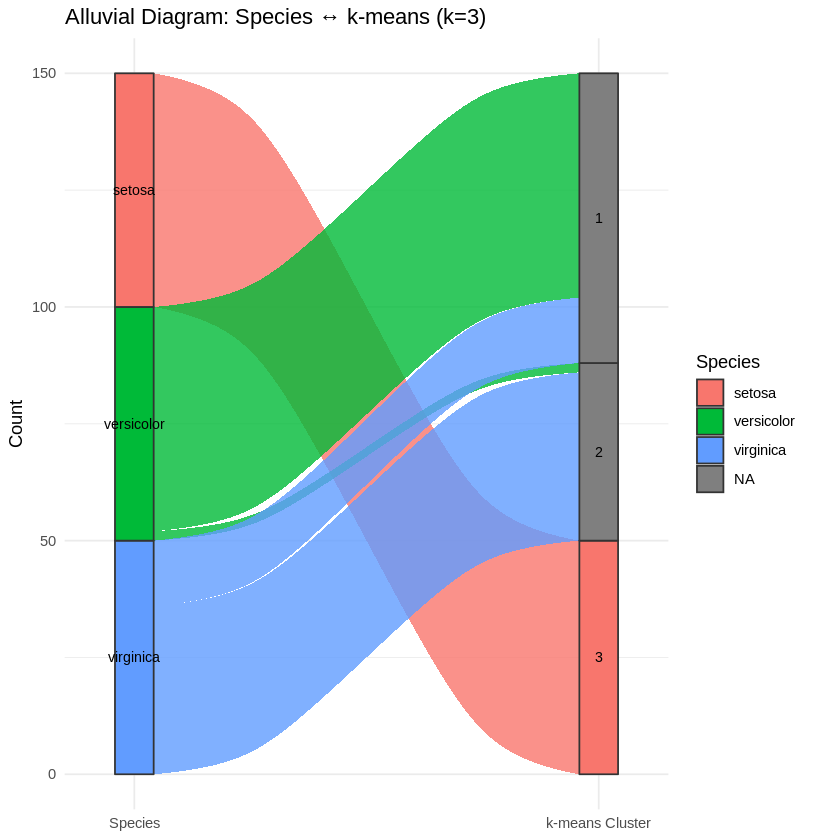

In [28]:
# ---- Alluvial: Species vs k-means clusters ----
need <- c("ggalluvial")
miss <- need[!(need %in% installed.packages()[,"Package"])]
if (length(miss)) install.packages(miss, repos = "https://cloud.r-project.org")
suppressPackageStartupMessages(library(ggalluvial))

# Assume you've defined:
#   iris_tbl <- as_tibble(iris)
#   num_cols <- iris_tbl %>% select(where(is.numeric))

set.seed(1)
k3 <- kmeans(num_cols, centers = 3, nstart = 25)
flow_df <- iris_tbl %>%
  mutate(Cluster = factor(k3$cluster)) %>%
  count(Species, Cluster)

ggplot(flow_df,
       aes(axis1 = Species, axis2 = Cluster, y = n, fill = Species)) +
  geom_alluvium(width = 1/12, alpha = 0.8) +
  geom_stratum(width = 1/12, color = "grey20") +
  geom_text(stat = "stratum", aes(label = after_stat(stratum)), size = 3) +
  scale_x_discrete(limits = c("Species", "k-means Cluster"), expand = c(.1, .05)) +
  labs(title = "Alluvial Diagram: Species ↔ k-means (k=3)", y = "Count") +
  theme_minimal()

## **Interpretation of the Alluvial Diagram**

The alluvial diagram (Figure above) illustrates the relationship between the true Iris species labels and the clusters identified through the unsupervised k-means algorithm (k = 3).

Each flow represents the number of samples shared between a species and its assigned cluster, highlighting the degree of alignment between the machine-derived clusters and the biological taxonomy.

The diagram shows a nearly perfect correspondence between Iris setosa (red) and a single cluster, confirming that Setosa is linearly separable from the other species based on its distinct morphological characteristics.

In contrast, Versicolor (green) and Virginica (blue) display partial overlap across clusters, reflecting the more gradual boundary between these two species in terms of petal and sepal dimensions. This overlap is expected given their moderate feature similarity and reinforces the notion that while k-means clustering effectively identifies the primary structure of the dataset, it cannot perfectly separate classes with intermediate characteristics.

Overall, the visualization demonstrates that unsupervised learning techniques can recover most of the inherent biological grouping in the Iris data, validating the discriminative strength of the measured features—particularly petal length and width—and offering a clear bridge between exploratory clustering and supervised classification.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



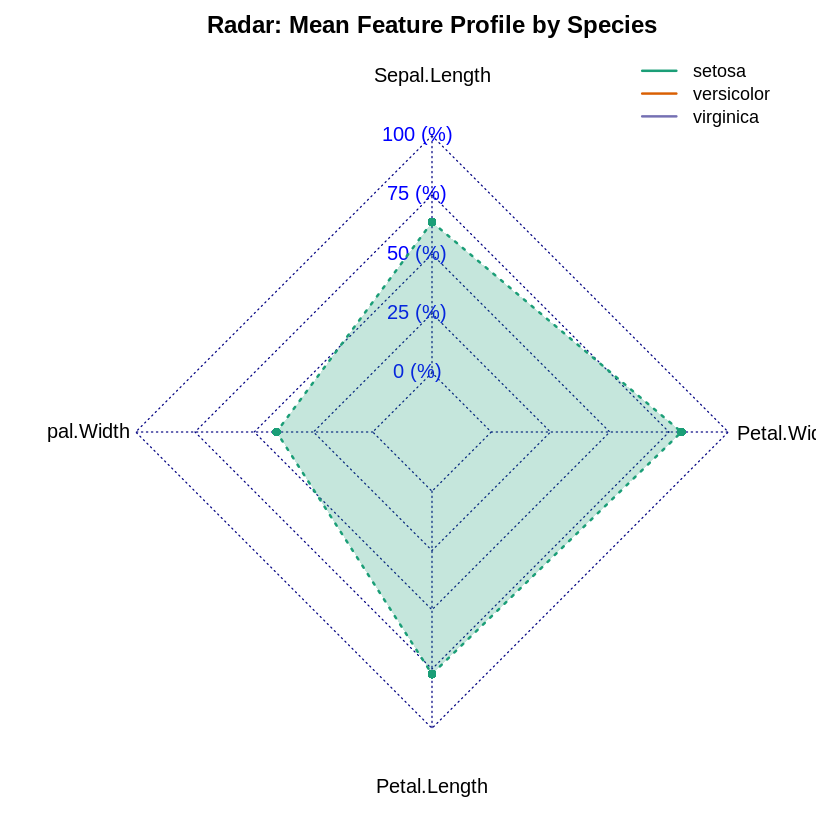

In [29]:
# ---- Radar chart of class means ----
need <- c("fmsb")
miss <- need[!(need %in% installed.packages()[,"Package"])]
if (length(miss)) install.packages(miss, repos = "https://cloud.r-project.org")
suppressPackageStartupMessages(library(fmsb))

# Class means (wide)
means_wide <- iris_tbl %>%
  group_by(Species) %>%
  summarise(across(where(is.numeric), mean), .groups = "drop")

# Max/min rows required by fmsb::radarchart
max_row <- num_cols %>% summarise(across(everything(), max)) %>% mutate(Species = "max")
min_row <- num_cols %>% summarise(across(everything(), min)) %>% mutate(Species = "min")

radar_df <- bind_rows(max_row, min_row, means_wide) %>%
  relocate(Species)

# fmsb expects rownames and numeric-only columns after
radar_mat <- as.data.frame(radar_df)
rownames(radar_mat) <- radar_mat$Species
radar_mat$Species <- NULL

# Single radar chart with all three species
op <- par(mar = c(1, 2, 2, 1))
fmsb::radarchart(
  radar_mat,
  axistype = 1,
  pcol = c(NA, NA, "#1b9e77", "#d95f02", "#7570b3"),
  pfcol = c(NA, NA, scales::alpha("#1b9e77", .25),
                      scales::alpha("#d95f02", .25),
                      scales::alpha("#7570b3", .25)),
  plwd = 2,
  title = "Radar: Mean Feature Profile by Species"
)
legend("topright",
       legend = rownames(radar_mat)[-(1:2)],
       bty = "n",
       col = c("#1b9e77", "#d95f02", "#7570b3"),
       lwd = 2, cex = .9)
par(op)

### **Interpretation of the Radar Chart**

The radar chart (Figure above) illustrates the mean feature profiles of the three Iris species—Setosa, Versicolor, and Virginica—across the four measured morphological variables: Sepal.Length, Sepal.Width, Petal.Length, and Petal.Width.

Each axis represents a feature, and the distance from the center indicates the relative magnitude of the mean standardized value for that feature.

The plot reveals distinct geometric patterns corresponding to each species. Setosa forms the smallest and most compact polygon, characterized by short petal dimensions but relatively wider sepals.

Versicolor occupies an intermediate position across all features, showing a balanced shape that bridges the differences between Setosa and Virginica. Virginica, on the other hand, forms the largest polygon, indicating the greatest mean petal length and width, consistent with its larger overall flower morphology.

This visual pattern reinforces that petal dimensions are the most discriminating characteristics among species, while sepal features exhibit smaller interspecies variation.

## **Reference**
Gupta, T., Arora, P., Rani, R., Jaiswal, G., Bansal, P., & Dev, A. (2022, December 1). Classification of Flower Dataset using Machine Learning Models. IEEE Xplore. https://doi.org/10.1109/AIST55798.2022.10065178


Mani, N., Premkumar Murugiah, Vethavarna Veeraraghavan, Nuzha Razia, & Ramesh, S. (2024). Enhancing Accuracy: Iris Flower Classification with Ensemble Models. https://doi.org/10.1109/icc-robins60238.2024.10534032

Saddala, R. R., Radha, D., & Devi, V. S. K. (2025). Predictive Maintenance Analysis Using Multivariate Machine Performance Data for Industrial Downtime Reduction. 2025 3rd International Conference on Intelligent Data Communication Technologies and Internet of Things (IDCIoT), 2283–2288. https://doi.org/10.1109/idciot64235.2025.10915129

‌